<a href="https://colab.research.google.com/github/Page0526/Pytorch-crash-course/blob/main/deep-neural-networks/nlp/Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem
Your task is to reimplement Word2Vec algorithm, train the model on WikiText-103, and visualize the word embeddings using t-SNE. To make the visualization readable, you should not visualize all the words, about 100 words are enough for demonstration purposes.

Your submission is a Jupyter notebook file with the t-SNE visualization (I will not re-run your notebook to create the visualization).

# Example of unoptimized Word2Vec

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
corpus = """
From Wikipedia, the free encyclopedia

Example of a single industrial control loop; showing continuously modulated control of process flow.
A closed-loop controller or feedback controller is a control loop which incorporates feedback, in contrast to an open-loop controller or non-feedback controller. A closed-loop controller uses feedback to control states or outputs of a dynamical system. Its name comes from the information path in the system: process inputs (e.g., voltage applied to an electric motor) have an effect on the process outputs (e.g., speed or torque of the motor), which is measured with sensors and processed by the controller; the result (the control signal) is "fed back" as input to the process, closing the loop.[1]

In the case of linear feedback systems, a control loop including sensors, control algorithms, and actuators is arranged in an attempt to regulate a variable at a setpoint (SP). An everyday example is the cruise control on a road vehicle; where external influences such as hills would cause speed changes, and the driver has the ability to alter the desired set speed. The PID algorithm in the controller restores the actual speed to the desired speed in an optimum way, with minimal delay or overshoot, by controlling the power output of the vehicle's engine. Control systems that include some sensing of the results they are trying to achieve are making use of feedback and can adapt to varying circumstances to some extent. Open-loop control systems do not make use of feedback, and run only in pre-arranged ways.

Closed-loop controllers have the following advantages over open-loop controllers:

disturbance rejection (such as hills in the cruise control example above)
guaranteed performance even with model uncertainties, when the model structure does not match perfectly the real process and the model parameters are not exact
unstable processes can be stabilized
reduced sensitivity to parameter variations
improved reference tracking performance
improved rectification of random fluctuations[2]
In some systems, closed-loop and open-loop control are used simultaneously. In such systems, the open-loop control is termed feedforward and serves to further improve reference tracking performance.

A common closed-loop controller architecture is the PID controller.


A basic feedback loop
Open-loop and closed-loop
This section is an excerpt from Control loop § Open-loop and closed-loop.[edit]
Fundamentally, there are two types of control loop: open-loop control (feedforward), and closed-loop control (feedback).


An electromechanical timer, normally used for open-loop control based purely on a timing sequence, with no feedback from the process
In open-loop control, the control action from the controller is independent of the "process output" (or "controlled process variable"). A good example of this is a central heating boiler controlled only by a timer, so that heat is applied for a constant time, regardless of the temperature of the building. The control action is the switching on/off of the boiler, but the controlled variable should be the building temperature, but is not because this is open-loop control of the boiler, which does not give closed-loop control of the temperature.

In closed loop control, the control action from the controller is dependent on the process output. In the case of the boiler analogy this would include a thermostat to monitor the building temperature, and thereby feed back a signal to ensure the controller maintains the building at the temperature set on the thermostat. A closed loop controller therefore has a feedback loop which ensures the controller exerts a control action to give a process output the same as the "reference input" or "set point". For this reason, closed loop controllers are also called feedback controllers.[3]

The definition of a closed loop control system according to the British Standards Institution is "a control system possessing monitoring feedback, the deviation signal formed as a result of this feedback being used to control the action of a final control element in such a way as to tend to reduce the deviation to zero."[4]

Likewise; "A Feedback Control System is a system which tends to maintain a prescribed relationship of one system variable to another by comparing functions of these variables and using the difference as a means of control."[5]
Closed-loop transfer function
Main article: Closed-loop transfer function
The output of the system y(t) is fed back through a sensor measurement F to a comparison with the reference value r(t). The controller C then takes the error e (difference) between the reference and the output to change the inputs u to the system under control P. This is shown in the figure. This kind of controller is a closed-loop controller or feedback controller.

This is called a single-input-single-output (SISO) control system; MIMO (i.e., Multi-Input-Multi-Output) systems, with more than one input/output, are common. In such cases variables are represented through vectors instead of simple scalar values. For some distributed parameter systems the vectors may be infinite-dimensional (typically functions).

A simple feedback control loop
If we assume the controller C, the plant P, and the sensor F are linear and time-invariant (i.e., elements of their transfer function C(s), P(s), and F(s) do not depend on time), the systems above can be analysed using the Laplace transform on the variables. This gives the following relations:

PID feedback control
Main article: PID controller

A block diagram of a PID controller in a feedback loop, r(t) is the desired process value or "set point", and y(t) is the measured process value.
A proportional–integral–derivative controller (PID controller) is a control loop feedback mechanism control technique widely used in control systems.

A PID controller continuously calculates an error value e(t) as the difference between a desired setpoint and a measured process variable and applies a correction based on proportional, integral, and derivative terms. PID is an initialism for Proportional-Integral-Derivative, referring to the three terms operating on the error signal to produce a control signal.

The theoretical understanding and application dates from the 1920s, and they are implemented in nearly all analogue control systems; originally in mechanical controllers, and then using discrete electronics and later in industrial process computers. The PID controller is probably the most-used feedback control design.

If u(t) is the control signal sent to the system, y(t) is the measured output and r(t) is the desired output, and e(t) = r(t) − y(t) is the tracking error, a PID controller has the general form

However, in practice, a pure differentiator is neither physically realizable nor desirable[6] due to amplification of noise and resonant modes in the system. Therefore, a phase-lead compensator type approach or a differentiator with low-pass roll-off are used instead.
"""

# corpus = """A closed-loop controller or feedback controller is a control loop which incorporates feedback, in contrast to an open-loop controller or non-feedback controller. A closed-loop controller uses feedback to control states or outputs of a dynamical system. Its name comes from the information path in the system: process inputs (e.g., voltage applied to an electric motor) have an effect on the process outputs (e.g., speed or torque of the motor), which is measured with sensors and processed by the controller; the result (the control signal) is "fed back" as input to the process, closing the loop"""


In [ ]:
import re
import random

# generate training dataset
# for skip-gram negative sampling word2vec model
def create_dataset(corpus: str, window=2):
  # return dataset, V
  corpus = corpus.lower() # lower all characters
  # remove all non-alphabetic characters
  corpus = re.sub(r'[^a-z\s]', '', corpus).split()
  # print(corpus)
  vocab = sorted(set(corpus)) # save dictionary
  print(vocab)
  # V = len(vocab)
  word_to_idx = {w: i for i, w in enumerate(vocab)} # map each word to unique index
  idx_to_word = {i: w for i, w in enumerate(vocab)} # reverse dictionary

  data_pos = []
  # window mean range of context word respect to target word
  for i in range(window, len(corpus) - window - 1):
    context = corpus[i-window : i+window+1]
    del context[window] # delete target word from context word set
    # print(f"{context=}")
    target = corpus[i]
    # print(f"{target=}")
    data_pos += [(target, c, 1) for c in context]

  data_neg = []
  V = len(vocab)
  vocab_list = list(vocab)
  # print(len(vocab_list))
  for w in vocab_list:
    for _ in range(2 * window):
      idx = random.randint(0, V-1)
      neg_sample = vocab_list[idx]
      data_neg.append((w, neg_sample, 0))

  data = data_pos + data_neg
  random.shuffle(data)

  return vocab, data, word_to_idx, idx_to_word


In [ ]:
vocab, data, word_to_idx, idx_to_word = create_dataset(corpus=corpus)

['a', 'ability', 'above', 'according', 'achieve', 'action', 'actual', 'actuators', 'adapt', 'advantages', 'algorithm', 'algorithms', 'all', 'also', 'alter', 'amplification', 'an', 'analogue', 'analogy', 'analysed', 'and', 'another', 'application', 'applied', 'applies', 'approach', 'architecture', 'are', 'arranged', 'article', 'as', 'assume', 'at', 'attempt', 'back', 'based', 'basic', 'be', 'because', 'being', 'between', 'block', 'boiler', 'british', 'building', 'but', 'by', 'c', 'calculates', 'called', 'can', 'case', 'cases', 'cause', 'central', 'change', 'changes', 'circumstances', 'closed', 'closedloop', 'closedloopedit', 'closing', 'comes', 'common', 'comparing', 'comparison', 'compensator', 'computers', 'constant', 'continuously', 'contrast', 'control', 'controlled', 'controller', 'controllers', 'controlling', 'correction', 'cruise', 'cs', 'dates', 'definition', 'delay', 'depend', 'dependent', 'derivative', 'design', 'desirable', 'desired', 'deviation', 'diagram', 'difference', 'di

In [ ]:
# V: vocab size
# d: dimension of the embedding
# w: V x d
# c: V x d
# Find w, c such that the loss is minimized
# Loss: BCE Loss

import matplotlib.pyplot as plt
import tqdm

def train(w, c, data, lr, n_epochs=10):
  lossf = nn.BCELoss()
  losses = []

  for ei in tqdm.trange(n_epochs):
    # print(f"Epoch {ei+1}/{n_epochs}")
    for di in data:
      i = word_to_idx[di[0]]
      j = word_to_idx[di[1]]
      wi = w[i, :]
      cj = c[j, :]
      wi = wi.reshape(-1, 1).requires_grad_()
      cj = cj.reshape(-1, 1).requires_grad_()
      pij = F.sigmoid(wi.T @ cj)
      # compute loss
      loss = lossf(pij, torch.FloatTensor([[di[2]]]))
      losses.append(loss.item())
      # backpropagate
      loss.backward()
      # udpate parameters
      with torch.no_grad():
        wi = wi - lr * wi.grad
        cj = cj - lr * cj.grad
      w[i, :] = wi.squeeze()
      c[j, :] = cj.squeeze()

  plt.plot(losses)

  return w, c

100%|██████████| 100/100 [03:36<00:00,  2.16s/it]


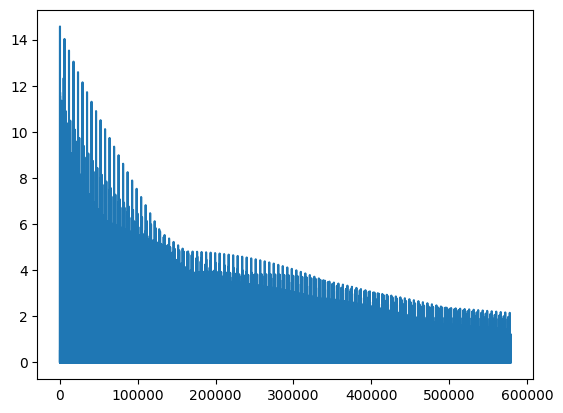

In [ ]:
d = 10
n_epochs = 100
lr = 1e-2

# initialize randomly target and context word
w = torch.randn(len(vocab), d)
c = torch.randn(len(vocab), d)
w, c = train(w=w, c=c, data=data, lr=lr, n_epochs=n_epochs)

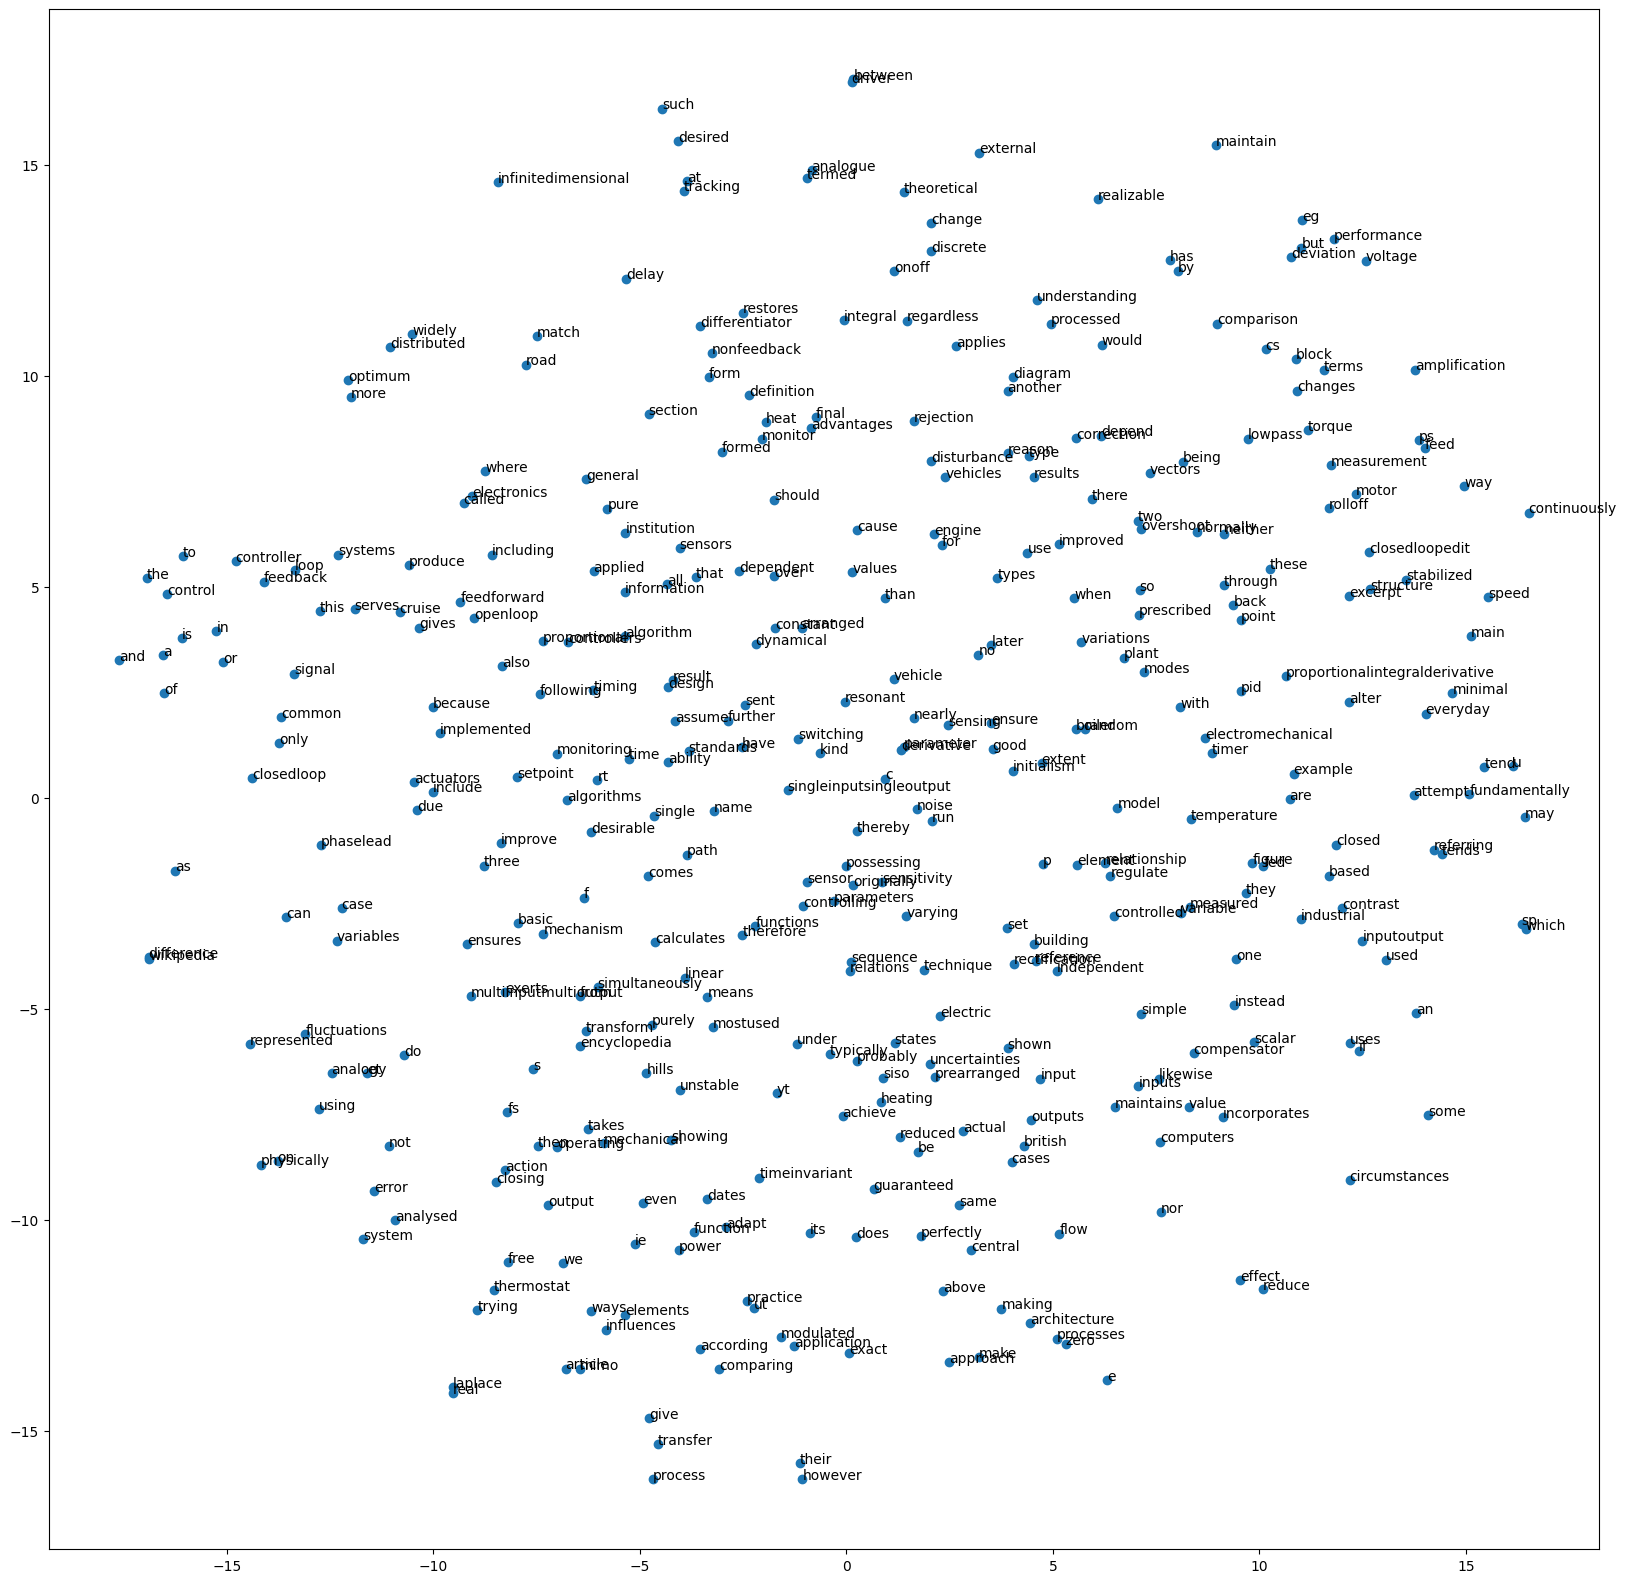

In [ ]:
# visualize the word vectors with t-SNE
from sklearn.manifold import TSNE
import numpy as np

vectors = w + c
# create new tensor sharing same data but disconnected from computational graph
vectors = vectors.detach().numpy()

tsne = TSNE(n_components=2)
vectors = tsne.fit_transform(vectors)

plt.figure(figsize=(20, 20))
plt.scatter(vectors[:, 0], vectors[:, 1])
for i, word in enumerate(vocab):
  # thêm chú thích các từ trong plot
  plt.annotate(word, (vectors[i, 0], vectors[i, 1]))
plt.show()


# My solution

In [2]:
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.0 MB/s eta 0:00:00


In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
import torch
import datasets

dataset = datasets.load_dataset('Salesforce/wikitext','wikitext-103-v1')

'''
Preprocessing process:
1. lowercase everything
2. remove all symbol otherthan a-z@#
3. split on spaces
4. remove stopwords/ empty token
5. apply snowball stemmer to remainder (reduce word to their base (root) form. VD: cared, caring, careful -> care)
'''
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

ss = SnowballStemmer('english')
sw = stopwords.words('english')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/722k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/156M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/156M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/655k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [5]:
dataset

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 1801350
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})

In [6]:
# check data sample
for i in range(5):
  print(dataset['train'][i])
  print()

{'text': ''}

{'text': ' = Valkyria Chronicles III = \n'}

{'text': ''}

{'text': ' Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . \n'}

{'text': " The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustme

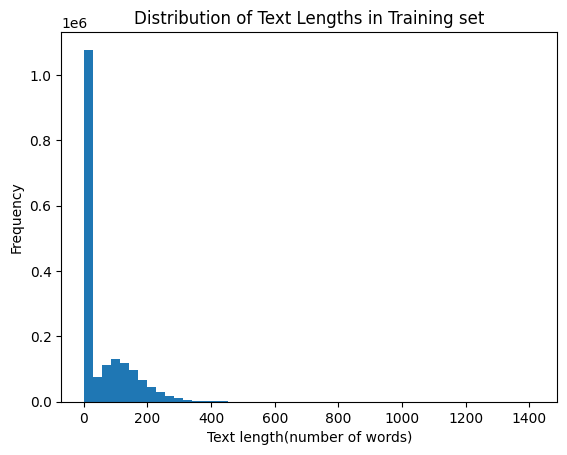

In [7]:
import matplotlib.pyplot as plt

# get length of each text sample in dataset
train_length_texts = [len(sample['text'].split()) for sample in dataset['train']]

# plot the distribution length
plt.hist(train_length_texts, bins=50)
plt.xlabel('Text length(number of words)')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths in Training set')
plt.show()

In [7]:
tweet_dataset = datasets.load_dataset('tweets_hate_speech_detection')

README.md:   0%|          | 0.00/5.58k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.07M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/31962 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/17197 [00:00<?, ? examples/s]

In [8]:
tweet_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'tweet'],
        num_rows: 31962
    })
    test: Dataset({
        features: ['label', 'tweet'],
        num_rows: 17197
    })
})

In [45]:
def split_tokens(row):                             # STEP
    row['all_tokens'] = [ss.stem(i) for i in       # 5
                     re.split(r" +",               # 3
                     re.sub(r"[^a-z@# ]", "",      # 2
                            row['text'].lower())) # 1
                     if (i not in sw) and len(i)]  # 4
    return row

# determine vocab to create mapping
dataset = dataset.map(split_tokens)

Map:   0%|          | 0/4358 [00:00<?, ? examples/s]

Map:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [46]:
dataset['train']['all_tokens']

[[],
 ['valkyria', 'chronicl', 'iii'],
 [],
 ['senj',
  'valkyria',
  'unk',
  'chronicl',
  'japanes',
  'lit',
  'valkyria',
  'battlefield',
  'common',
  'refer',
  'valkyria',
  'chronicl',
  'iii',
  'outsid',
  'japan',
  'tactic',
  'role',
  '@@',
  'play',
  'video',
  'game',
  'develop',
  'sega',
  'mediavis',
  'playstat',
  'portabl',
  'releas',
  'januari',
  'japan',
  'third',
  'game',
  'valkyria',
  'seri',
  'employ',
  'fusion',
  'tactic',
  'real',
  '@@',
  'time',
  'gameplay',
  'predecessor',
  'stori',
  'run',
  'parallel',
  'first',
  'game',
  'follow',
  'nameless',
  'penal',
  'militari',
  'unit',
  'serv',
  'nation',
  'gallia',
  'second',
  'europan',
  'war',
  'perform',
  'secret',
  'black',
  'oper',
  'pit',
  'imperi',
  'unit',
  'unk',
  'raven'],
 ['game',
  'began',
  'develop',
  'carri',
  'larg',
  'portion',
  'work',
  'done',
  'valkyria',
  'chronicl',
  'ii',
  'retain',
  'standard',
  'featur',
  'seri',
  'also',
  'under

In [ ]:
print(dataset)

DatasetDict({
    test: Dataset({
        features: ['text', 'all_tokens', 'tokens', 'moving_window'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text', 'all_tokens', 'tokens', 'moving_window'],
        num_rows: 1801350
    })
    validation: Dataset({
        features: ['text', 'all_tokens', 'tokens', 'moving_window'],
        num_rows: 3760
    })
})


In [1]:
from collections import Counter

counts = Counter([i for s in dataset['train']['all_tokens'] for i in s])
counts = {k:v for k, v in counts.items() if v>10} # Filtering
vocab = list(counts.keys())
n_v = len(vocab)

id2tok = dict(enumerate(vocab))
tok2id = {token: id for id, token in id2tok.items()}

# Now correct tokens
def remove_rare_tokens(row):
    row['tokens'] = [t for t in row['all_tokens'] if t in vocab]
    return row

dataset = dataset.map(remove_rare_tokens)

NameError: name 'dataset' is not defined

In [42]:
counts

{' ': 102590700,
 '=': 1466599,
 'V': 249932,
 'a': 33404171,
 'l': 16074767,
 'k': 2902435,
 'y': 5975737,
 'r': 26125898,
 'i': 28746348,
 'C': 1315889,
 'h': 18951219,
 'o': 28620646,
 'n': 29527723,
 'c': 12046566,
 'e': 48811316,
 's': 25022043,
 'I': 1000793,
 '\n': 1165029,
 'S': 1594774,
 'j': 371559,
 'ō': 5976,
 '3': 536939,
 ':': 181247,
 '<': 445711,
 'u': 10605973,
 '>': 445814,
 '(': 583522,
 'J': 502201,
 'p': 7455653,
 '戦': 11,
 'の': 95,
 'ヴ': 17,
 'ァ': 71,
 'ル': 225,
 'キ': 12,
 'ュ': 12,
 'リ': 78,
 'ア': 59,
 ',': 5120771,
 't': 33936296,
 '.': 4157830,
 'f': 8422062,
 'B': 1038129,
 'd': 15946089,
 ')': 583875,
 'm': 9359363,
 '@': 2377841,
 '-': 895584,
 'g': 7654978,
 'v': 3966435,
 'b': 5390296,
 'M': 1090850,
 'P': 773739,
 'R': 720549,
 '2': 1067578,
 '0': 1606670,
 '1': 1789819,
 'E': 518243,
 'w': 6506409,
 '"': 1338685,
 'N': 598215,
 'G': 595891,
 'W': 638864,
 'T': 1703727,
 'H': 836989,
 'O': 460431,
 'z': 401618,
 'A': 1514857,
 "'": 947523,
 'x': 742646,
 '

In [11]:
def windowizer(row, wsize=3):
    """
    Windowizer function for Word2Vec. Converts sentence to sliding-window
    pairs.
    """
    doc = row['tokens']
    wsize = 3
    out = []
    for i, wd in enumerate(doc):
        target = tok2id[wd]
        window = [i+j for j in
                  range(-wsize, wsize+1, 1)
                  if (i+j>=0) &
                     (i+j<len(doc)) &
                     (j!=0)]

        out+=[(target, tok2id[doc[w]]) for w in window]
    row['moving_window'] = out
    return row

dataset = dataset.map(windowizer)

Map:   0%|          | 0/4358 [00:00<?, ? examples/s]

Map:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [12]:
from torch.utils.data import Dataset, DataLoader

class Word2VecDataset(Dataset):
  '''
  Takes a HuggingFace dataset as input, to be used for a Word2Vec Dataloader
  '''
  def __init__(self, dataset, vocab_size, wsize=3):
    self.dataset = dataset
    self.vocab_size = vocab_size
    self.data = [i for s in dataset['moving_window'] for i in s]

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [19]:
BATCH_SIZE = 2**14
N_WORKERS = 10

dataloader = {}

for key in dataset.keys():
  dataloader[key] = DataLoader(Word2VecDataset(dataset[key], vocab_size=n_v), batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Building Neural Network

In [21]:
for key in dataloader.keys():
  print(key)

test
train
validation


### Manually one-hot-encoding

In [22]:
from torch import nn

size = 10
input = 3

def one_hot_encode(input, size):
  vec = torch.zeros(size).float()
  vec[input] = 1.0
  return vec

ohe = one_hot_encode(input, size)
linear_layer = nn.Linear(size, 1, bias=False)

# set edge weight from 0 to 9 easy inference
with torch.no_grad():
  linear_layer.weight = nn.Parameter(torch.arange(10, dtype=torch.float).reshape(linear_layer.weight.shape))

print(linear_layer.weight)
# when pass ohe, retrieve weight corresponding to the input id
print(linear_layer(ohe))

Parameter containing:
tensor([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]], requires_grad=True)
tensor([3.], grad_fn=<SqueezeBackward4>)


In [ ]:
embedding_layer = nn.Embedding(size, 1)
with torch.no_grad():
  embedding_layer.weight=nn.Parameter(torch.arange(10, dtype=torch.float).reshape(embedding_layer.weight.shape))

  print(embedding_layer.weight)
  print(embedding_layer(torch.tensor(input)))

NameError: name 'size' is not defined

In [23]:
class Word2Vec(nn.Module):
  def __init__(self, vocab_size, embedding_size):
    super().__init__()
    self.embed = nn.Embedding(vocab_size, embedding_size)
    self.expand = nn.Linear(embedding_size, vocab_size, bias=False)

  def forward(self, input):
    # encoder input to lower-representation
    hidden = self.embed(input)
    # expand hidden layer to predictions
    logits = self.expand(hidden)
    return logits

In [24]:
EMBED_SIZE = 100
# instantiate model
model = Word2Vec(n_v, EMBED_SIZE)

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
model.to(device)

LR = 3e-4
EPOCHS = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

In [25]:
!pip show tqdm

Name: tqdm
Version: 4.66.5
Summary: Fast, Extensible Progress Meter
Home-page: https://tqdm.github.io
Author: 
Author-email: 
License: MPL-2.0 AND MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: bigquery-magics, cmdstanpy, datasets, dopamine_rl, gdown, google-generativeai, huggingface-hub, hyperopt, ipyparallel, kaggle, kagglehub, moviepy, nltk, panel, proglog, prophet, spacy, tensorflow-datasets, transformers


In [26]:
from tqdm import tqdm
progress_bar = tqdm(range(EPOCHS * len(dataloader['train'])))
running_loss = []
for epoch in range(EPOCHS):
  epoch_loss=0
  for center, context in dataloader['train']:
    # target word vs context words
    center, context = center.to(device), context.to(device)
    optimizer.zero_grad()
    logits = model(input=context)
    loss = loss_fn(logits, center)
    # loss is a tensor, loss.item() -> regular number float
    epoch_loss += loss.item()
    loss.backward()
    optimizer.step()
    progress_bar.update(1)

  epoch_loss/=len(dataloader['train'])
  running_loss.append(epoch_loss)

  0%|          | 0/230 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 96%|█████████▌| 220/230 [00:23<00:00, 12.34it/s]

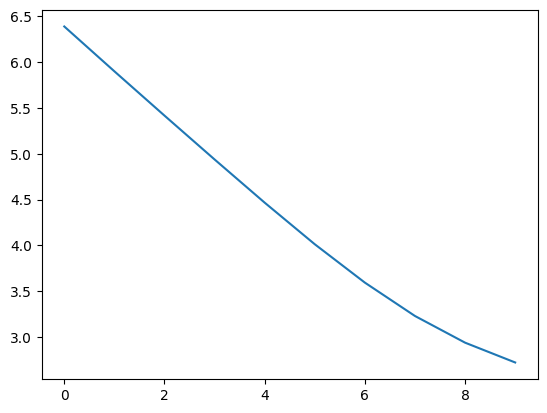

In [27]:
plt.plot(running_loss)

In [34]:
wordvecs = model.expand.weight.cpu().detach().numpy()
tokens = ['over', 'game','began','development']

from scipy.spatial import distance
import numpy as np

def get_distance_matrix(wordvecs, metric):
  dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
  return dist_matrix

def get_k_similar_words(word, dist_matrix, k=10):
  idx = tok2id[word]
  dists = dist_matrix[idx]
  ind = np.argpartition(dists, k)[:k+1]
  ind = ind[np.argsort(dists[ind])][1:]
  out = [(i, id2tok[i], dists[i]) for i in ind]
  return out

dmat = get_distance_matrix(wordvecs, 'cosine')
for word in tokens:
  print(word, [t[1] for t in get_k_similar_words(word, dmat)], "\n")

KeyError: 'over'